In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./data/employee_retention.csv",)

In [3]:
print(df.shape)
df.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [4]:
# 看看員工id是不是都只有一個
print("員工id都只有一個：",len(df["employee_id"].unique()) == df.shape[0])

員工id都只有一個： True


In [5]:
# 年資99的有點怪
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [6]:
# 明顯要刪掉年資99, 98的
df["seniority"].sort_values(ascending=False)

24701    99
24700    98
11717    29
12013    29
647      29
         ..
13181     1
13201     1
13210     1
5063      1
10922     1
Name: seniority, Length: 24702, dtype: int64

In [7]:
# 刪除年資99,98的兩筆
df=df.loc[df["seniority"]<98]

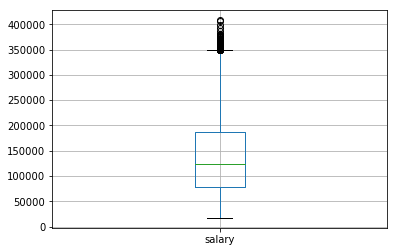

In [8]:
# 薪水沒有看起來非常不合理的
df.boxplot(column=["salary"])

In [9]:
# 檢查日期看起來沒有不合理的
print("======= join date =======")
print(df["join_date"].min())
print(df["join_date"].max())
print("======= quit date =======")
print(pd.to_datetime(df["quit_date"]).min())
print(pd.to_datetime(df["quit_date"]).max())

======= join date =======
2011-01-24
2015-12-10
======= quit date =======
2011-10-13 00:00:00
2015-12-09 00:00:00


### 1. Estimate headcount

In [11]:
# 創造config table
company_df = pd.DataFrame({"company_id":sorted(df["company_id"].unique())})          
hc_df = pd.DataFrame()
hc_df["date"] = pd.date_range(start="2011-01-24",end="2015-12-13")
hc_df = hc_df.merge(company_df,how="cross")

In [12]:
# 整理join資料
join_df = pd.DataFrame(df.groupby(["join_date","company_id"]).size()).reset_index().rename(columns={0:'n_join'})
join_df["join_date"] = pd.to_datetime(join_df["join_date"])
join_df.head()

,join_date,company_id,n_join
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


In [13]:
# 整理quit資料
quit_df = pd.DataFrame(df.groupby(["quit_date","company_id"]).size()).reset_index().rename(columns={0:'n_quit'})
quit_df["quit_date"] = pd.to_datetime(quit_df["quit_date"])
quit_df.head()

,quit_date,company_id,n_quit
0,2011-10-13,6,1
1,2011-10-14,10,1
2,2011-10-21,1,1
3,2011-10-28,4,1
4,2011-11-11,1,1


In [14]:
# 合併join, quit兩個資料
hc_df = pd.merge(hc_df,join_df,left_on=["date","company_id"],right_on=["join_date","company_id"],how="left")
hc_df = pd.merge(hc_df,quit_df,left_on=["date","company_id"],right_on=["quit_date","company_id"],how="left")
hc_df = hc_df.drop(["join_date","quit_date"],axis=1).fillna(0)
hc_df["diff"] = hc_df["n_join"] - hc_df["n_quit"]
hc_df["headcount"] = hc_df.groupby(['company_id'])['diff'].cumsum()
hc_df

,date,company_id,n_join,n_quit,diff,headcount
0,2011-01-24,1,25.0,0.0,25.0,25.0
1,2011-01-24,2,17.0,0.0,17.0,17.0
2,2011-01-24,3,9.0,0.0,9.0,9.0
3,2011-01-24,4,12.0,0.0,12.0,12.0
4,2011-01-24,5,5.0,0.0,5.0,5.0
...,...,...,...,...,...,...
21415,2015-12-13,8,0.0,0.0,0.0,468.0
21416,2015-12-13,9,0.0,0.0,0.0,432.0
21417,2015-12-13,10,0.0,0.0,0.0,385.0
21418,2015-12-13,11,0.0,0.0,0.0,4.0


In [15]:
hc_df.loc[hc_df["company_id"]==1]

,date,company_id,n_join,n_quit,diff,headcount
0,2011-01-24,1,25.0,0.0,25.0,25.0
12,2011-01-25,1,2.0,0.0,2.0,27.0
24,2011-01-26,1,2.0,0.0,2.0,29.0
36,2011-01-27,1,0.0,0.0,0.0,29.0
48,2011-01-28,1,0.0,0.0,0.0,29.0
...,...,...,...,...,...,...
21360,2015-12-09,1,1.0,0.0,1.0,3864.0
21372,2015-12-10,1,1.0,0.0,1.0,3865.0
21384,2015-12-11,1,0.0,0.0,0.0,3865.0
21396,2015-12-12,1,0.0,0.0,0.0,3865.0


### 2. Why employee churn?

survival analysis
- 屬於right-censored資料（只知道停留了多久）
- reference: https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html

In [16]:
# 假設資料搜集的時間最後是在2015-12-13
df["end_date"] = df["quit_date"]
df["end_date"] = df["end_date"].fillna(pd.to_datetime("2015-12-13"))

In [17]:
# 留存的時間，還有right censored資料label
df["stay_day"] = (pd.to_datetime(df["end_date"])-pd.to_datetime(df["join_date"])).astype('timedelta64[D]')
df['churn'] = df.apply(lambda x: False if pd.isnull(x['quit_date']) else True, axis=1)
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,end_date,stay_day,churn
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2015-10-30,585.0,True
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2014-04-04,340.0,True
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2015-12-13 00:00:00,426.0,False
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2013-06-07,389.0,True
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2014-08-22,1040.0,True


1. 每個分析公司的存活率曲線都差不多，不會有公司特別容易異動

（除了company11, company12較少資料，曲線算出來比較不平緩）
-> 正式的應該要用logrank test(?)去檢定曲線之間的差異

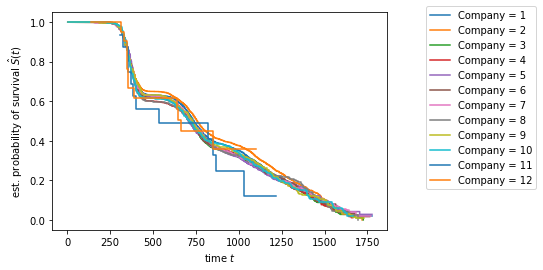

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

for company in sorted(df["company_id"].unique()):
    time, survival_prob = kaplan_meier_estimator(df.loc[df["company_id"]==company]["churn"], df.loc[df["company_id"]==company]["stay_day"])
    plt.step(time, survival_prob, where="post", label="Company = %s"% company)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best", bbox_to_anchor=(1.1, 1.05))

In [19]:
df.groupby(["company_id"]).size()

company_id
1     8485
2     4222
3     2749
4     2062
5     1755
6     1291
7     1224
8     1047
9      961
10     864
11      16
12      24
dtype: int64

- 從圖來看data science和engineer部門的存活率更高一些，sales、marketing的存活率較低。

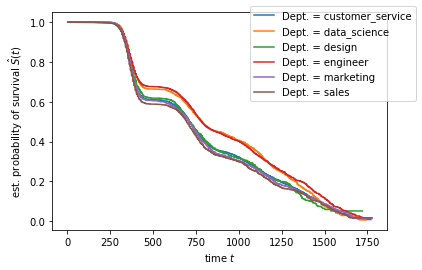

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

for dept in sorted(df["dept"].unique()):
    time, survival_prob = kaplan_meier_estimator(df.loc[df["dept"]==dept]["churn"], df.loc[df["dept"]==dept]["stay_day"])
    plt.step(time, survival_prob, where="post", label="Dept. = %s"% dept)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best", bbox_to_anchor=(1.1, 1.05))

### Multivariate Survival Models
- Cox’s proportional hazard’s model

In [21]:
from sksurv.preprocessing import OneHotEncoder
df["company_id"]= df["company_id"].astype(str)
# df["join_month"]= pd.to_datetime(df["join_date"]).dt.month.astype(str)
cox_df = pd.get_dummies(df.drop(["join_date","quit_date","end_date"],axis=1), drop_first=True)
cox_df.head()

,employee_id,seniority,salary,stay_day,churn,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,...,company_id_5,company_id_6,company_id_7,company_id_8,company_id_9,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,13021.0,28,89000.0,585.0,True,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,825355.0,20,183000.0,340.0,True,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,927315.0,14,101000.0,426.0,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,662910.0,20,115000.0,389.0,True,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,256971.0,23,276000.0,1040.0,True,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [22]:
# convert datatype
data_y = df[['churn', 'stay_day']].to_numpy()
aux = [(e1,e2) for e1,e2 in data_y]

#Structured array
data_y = np.array(aux, dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
data_y

array([( True, 585.), ( True, 340.), (False, 426.), ..., (False, 298.),
       (False,  48.), ( True, 780.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

In [23]:
data_x = cox_df.drop(["employee_id","churn","stay_day"],axis=1)

In [24]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis()

company11的影響力較大（但資料也較少）、在sales、marketing中也比較會流動。

In [26]:
# 為log hazard ratio.
pd.Series(list(map('{:.10f}'.format,estimator.coef_)), index=data_x.columns).sort_values(ascending=False)

company_id_11         0.2036134572
dept_sales            0.1574481857
dept_marketing        0.1115131710
dept_design           0.0884408683
dept_data_science     0.0511554932
dept_engineer         0.0241412067
company_id_4          0.0155677383
seniority             0.0102437211
company_id_12         0.0081288559
company_id_3          0.0039337721
company_id_2         -0.0562321300
company_id_7         -0.0297722015
company_id_9         -0.0261502610
company_id_5         -0.0201183094
company_id_6         -0.0158309917
company_id_8         -0.0089667124
company_id_10        -0.0036062258
salary               -0.0000017939
dtype: object

### Performance of Survival analysis
- 計算model performance(c-index)幾乎是random的（c-index可以想像成是AUC），整體模型表現偏低，fit的並不好

```estimator.score(data_x, data_y)```

In [27]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(data_y["Status"], data_y["Survival_in_days"], prediction)
result[0]

0.5348077076473194

### Feature Selection
- 單一變項放進去fit，去看c-index，幾乎也都沒什麼效果

In [28]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

salary               0.516117
dept_engineer        0.515455
dept_data_science    0.509932
dept_sales           0.508912
company_id_2         0.506516
dept_marketing       0.504441
company_id_4         0.502579
company_id_3         0.501908
company_id_8         0.501432
company_id_6         0.501108
company_id_5         0.500832
company_id_10        0.500783
dept_design          0.500619
company_id_7         0.500496
company_id_11        0.500108
company_id_9         0.500106
company_id_12        0.500094
seniority            0.499724
dtype: float64

### 外部因素（月份）

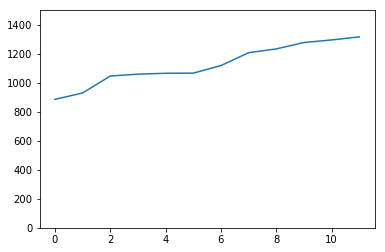

In [47]:
# 12月和2月離職的人少
pd.to_datetime(df["quit_date"]).dt.month.value_counts().sort_values().reset_index()["quit_date"].plot(ylim=(0,1500))

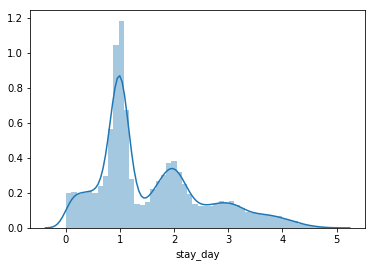

In [260]:
# 大約半年後離職就開始攀升，每隔一年有一個峰 -> 有可能
sns.distplot(df['stay_day']/365.5)
plt.show()

### Summary:
- 從留存率曲線來看，data science、engineer的部門留存率比較高一些。但從survival analysis中，整體model幾乎fit的不太好，c-index約在0.53。而從Feature Selection的角度看，無法看出company、seniority、salary對留存的影響，或許留存的內部因素沒有完全被捕捉（如：組織氣氛、薪資漲幅、工作壓力），或是更容易受到外在因素（如：離職月份）的影響。

In [261]:
df["quick_turnover"] = df

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,end_date,stay_day,right_censored,join_month
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,2015-10-30,585.0,False,3
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,2014-04-04,340.0,False,4
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN,2015-12-13 00:00:00,426.0,True,10
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,2013-06-07,389.0,False,5
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,2014-08-22,1040.0,False,10
...,...,...,...,...,...,...,...,...,...,...,...
24695,63273.0,1,data_science,5,172000.0,2012-05-01,2015-06-26,2015-06-26,1151.0,False,5
24696,94644.0,6,marketing,7,88000.0,2012-01-26,2013-02-01,2013-02-01,372.0,False,1
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaN,2015-12-13 00:00:00,298.0,True,2
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaN,2015-12-13 00:00:00,48.0,True,10


### 3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

- 通勤時間
- 工時
- 薪資漲幅